In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import time
import torchvision
import sys
import os
from argparse import ArgumentParser
from torchvision.datasets import CIFAR10 as data_cifar
from torchvision.transforms import Normalize, ToTensor, Compose, RandomCrop, RandomHorizontalFlip
from easydict import EasyDict
from torch.optim.lr_scheduler import MultiStepLR

In [4]:
# Upload resnet.py from the project folder with Google Chrome as the nrowser in colaboratory. 
from google.colab import drive, files
drive.mount('/content/drive/', force_remount=True)
src = list(files.upload().values())[0]
open('resnet.py','wb').write(src)
import resnet 


Mounted at /content/drive/


Saving resnet.py to resnet.py


In [3]:

args = EasyDict({"lr": 0.1, "resume":False})

transform_train = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = Compose([
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = data_cifar(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4)

testset = data_cifar(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
net = resnet.ResNetUse()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr ,
                      momentum=0.9, weight_decay = 1e-4)

# Training
scheduler = MultiStepLR(optimizer, milestones=[30,40], gamma=0.1)
train_losses = list()
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      train_loss += loss.item()
      loss.backward()
      optimizer.step()
    
    
      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
    train_losses.append(train_loss)
    print("Training Accuracy:", correct/total)

test_losses = list()
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        test_losses.append(test_loss)
    print("Testing Accuracy:", correct/total)


for epoch in range(0, 50):
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(epoch)
    scheduler.step()
    test(epoch)


current lr 1.00000e-01

Epoch: 0
Training Accuracy: 0.40486
Testing Accuracy: 0.5099
current lr 1.00000e-01

Epoch: 1
Training Accuracy: 0.60268
Testing Accuracy: 0.6446
current lr 1.00000e-01

Epoch: 2
Training Accuracy: 0.68606
Testing Accuracy: 0.7158
current lr 1.00000e-01

Epoch: 3
Training Accuracy: 0.73546
Testing Accuracy: 0.7378
current lr 1.00000e-01

Epoch: 4
Training Accuracy: 0.76714
Testing Accuracy: 0.747
current lr 1.00000e-01

Epoch: 5
Training Accuracy: 0.78616
Testing Accuracy: 0.738
current lr 1.00000e-01

Epoch: 6
Training Accuracy: 0.8007
Testing Accuracy: 0.7798
current lr 1.00000e-01

Epoch: 7
Training Accuracy: 0.8155
Testing Accuracy: 0.801
current lr 1.00000e-01

Epoch: 8
Training Accuracy: 0.82218
Testing Accuracy: 0.788
current lr 1.00000e-01

Epoch: 9
Training Accuracy: 0.83072
Testing Accuracy: 0.808
current lr 1.00000e-01

Epoch: 10
Training Accuracy: 0.83884
Testing Accuracy: 0.8105
current lr 1.00000e-01

Epoch: 11
Training Accuracy: 0.84536
Testing Ac

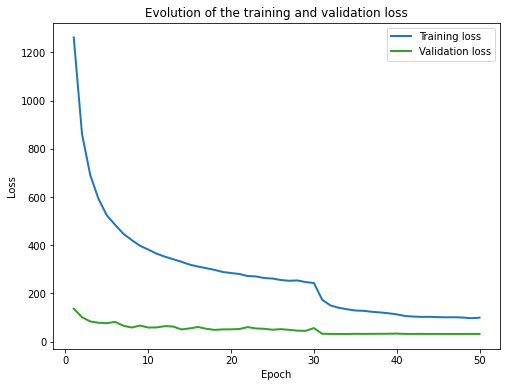

In [6]:
import matplotlib.pyplot as plt
import numpy as np

colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]
def plot_losses(train_losses, test_losses):
    x = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_losses, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, test_losses, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()
plot_losses(train_losses, test_losses)

In [8]:
print("The length of training set is:", len(trainset))
print("The length of test set is:", len(testset))


The length of training set is: 50000
The length of test set is: 10000
